In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

# FEATURE ENGINEERING

In [2]:
# Reloading dataset in chunks to process large data
CreditCardData = pd.read_csv('../data/creditcard.csv', chunksize=50000)

X_chunks = []
y_chunks = []

scaler = StandardScaler()

for chunk in CreditCardData:
    chunk['Hour'] = (chunk['Time'] // 3600) % 24
    chunk['Amount_Scaled'] = scaler.fit_transform(chunk[['Amount']])
    chunk = chunk.drop(columns=['Time', 'Amount'])

    X_chunks.append(chunk.drop(columns=['Class']))
    y_chunks.append(chunk['Class'])

X = pd.concat(X_chunks, ignore_index=True)
y = pd.concat(y_chunks, ignore_index=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()

((199364, 30),
 (85443, 30),
 0    199020
 1       344
 Name: Class, dtype: int64,
 0    85295
 1      148
 Name: Class, dtype: int64)

# SVM and Random Forest Models

In [3]:
# Initialize models
svm_model = SVC(kernel='rbf', random_state=42, class_weight='balanced')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Importing SMOTE for handling class imbalance

In [4]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

balanced_class_distribution = y_train_smote.value_counts()
balanced_class_distribution

0    199020
1    199020
Name: Class, dtype: int64

In [5]:
# Scaling the Amount feature
scaler = StandardScaler()
#CreditCardData['Amount_Scaled'] = scaler.fit_transform(CreditCardData[['Amount']])
# Reloading dataset in chunks to process large data
CreditCardData = pd.read_csv('../data/creditcard.csv', chunksize=50000)

X_chunks = []
y_chunks = []

scaler = StandardScaler()

for chunk in CreditCardData:
    chunk['Hour'] = (chunk['Time'] // 3600) % 24
    chunk['Amount_Scaled'] = scaler.fit_transform(chunk[['Amount']])  # Düzeltme burada zaten var
    chunk = chunk.drop(columns=['Time', 'Amount'])

    X_chunks.append(chunk.drop(columns=['Class']))
    y_chunks.append(chunk['Class'])

# Tüm dilimleri birleştir
X = pd.concat(X_chunks, ignore_index=True)
y = pd.concat(y_chunks, ignore_index=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [6]:
# Train SVM model
print("Training SVM model...")
svm_model.fit(X_train_smote, y_train_smote)

# Train Random Forest model
print("Training Random Forest model...")
rf_model.fit(X_train_smote, y_train_smote)

# --- Değerlendirme --- #
# Değerlendirme: Eğitim seti üzerindeki performans
print("\nEvaluating SVM model on training data...")
y_train_pred_svm = svm_model.predict(X_train_smote)
print("Confusion Matrix (Training SVM):")
print(confusion_matrix(y_train_smote, y_train_pred_svm))
print("Classification Report (Training SVM):")
print(classification_report(y_train_smote, y_train_pred_svm))

print("\nEvaluating Random Forest model on training data...")
y_train_pred_rf = rf_model.predict(X_train_smote)
print("Confusion Matrix (Training RF):")
print(confusion_matrix(y_train_smote, y_train_pred_rf))
print("Classification Report (Training RF):")
print(classification_report(y_train_smote, y_train_pred_rf))

# Değerlendirme: Test seti üzerindeki performans
print("\nEvaluating SVM model on test data...")
y_test_pred_svm = svm_model.predict(X_test)
print("Confusion Matrix (Test SVM):")
print(confusion_matrix(y_test, y_test_pred_svm))
print("Classification Report (Test SVM):")
print(classification_report(y_test, y_test_pred_svm))

print("\nEvaluating Random Forest model on test data...")
y_test_pred_rf = rf_model.predict(X_test)
print("Confusion Matrix (Test RF):")
print(confusion_matrix(y_test, y_test_pred_rf))
print("Classification Report (Test RF):")
print(classification_report(y_test, y_test_pred_rf))

Training SVM model...
Training Random Forest model...

Evaluating SVM model on training data...
Confusion Matrix (Training SVM):
[[196150   2870]
 [  5550 193470]]
Classification Report (Training SVM):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    199020
           1       0.99      0.97      0.98    199020

    accuracy                           0.98    398040
   macro avg       0.98      0.98      0.98    398040
weighted avg       0.98      0.98      0.98    398040


Evaluating Random Forest model on training data...
Confusion Matrix (Training RF):
[[199020      0]
 [     0 199020]]
Classification Report (Training RF):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       1.00      1.00      1.00    199020

    accuracy                           1.00    398040
   macro avg       1.00      1.00      1.00    398040
weighted avg       1.00      1.00      1.00

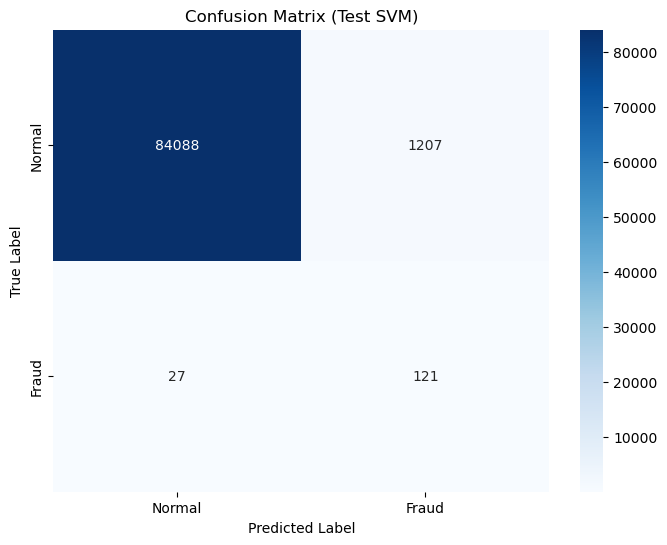

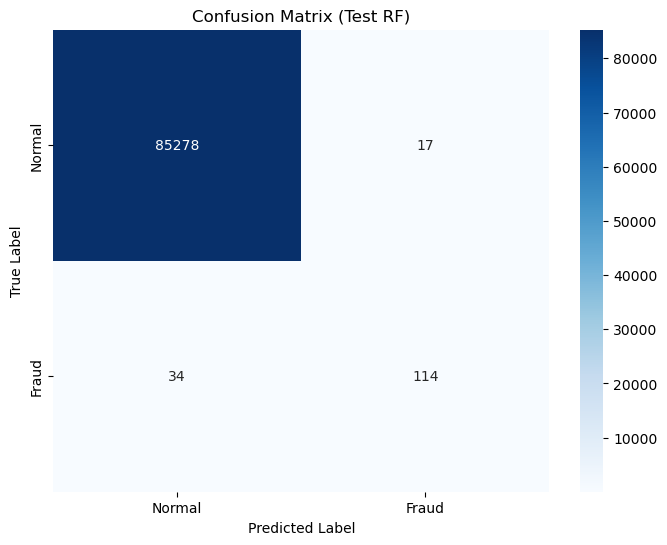

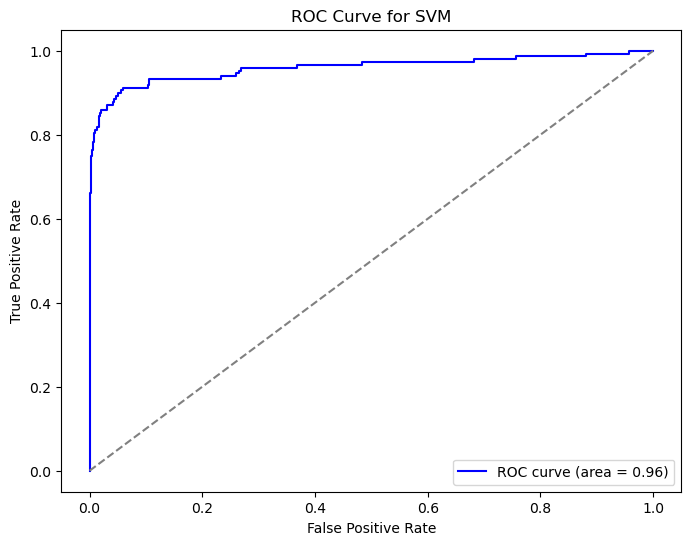

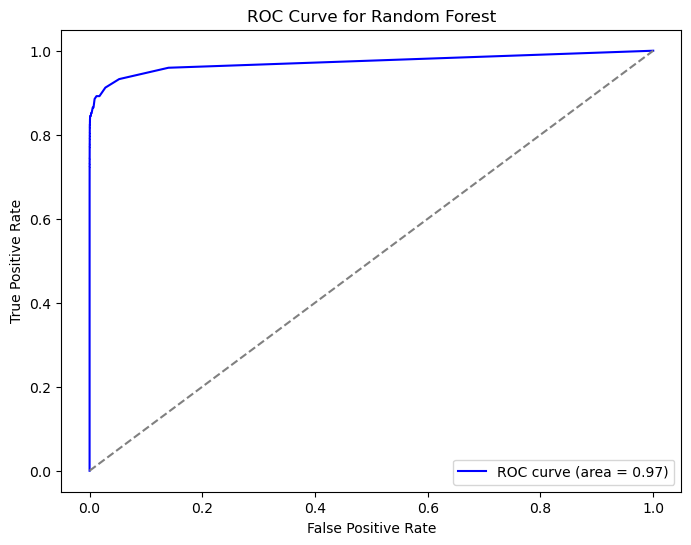

In [7]:
# Confusion Matrix Görselleştirme Fonksiyonu
def plot_confusion_matrix(cm, title='Confusion Matrix', labels=['Normal', 'Fraud']):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# ROC Eğrisi Görselleştirme Fonksiyonu
def plot_roc_curve(y_true, y_pred_proba, model_name='Model'):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# SVM Confusion Matrix
cm_svm = confusion_matrix(y_test, svm_model.predict(X_test))
plot_confusion_matrix(cm_svm, title='Confusion Matrix (Test SVM)')

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_model.predict(X_test))
plot_confusion_matrix(cm_rf, title='Confusion Matrix (Test RF)')

# SVM ROC Curve
plot_roc_curve(y_test, svm_model.decision_function(X_test), model_name='SVM')

# Random Forest ROC Curve
rf_prob = rf_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, rf_prob, model_name='Random Forest')

In [8]:
print("Modelin kullandığı özellikler:")
print(rf_model.feature_names_in_)


Modelin kullandığı özellikler:
['V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8' 'V9' 'V10' 'V11' 'V12' 'V13'
 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22' 'V23' 'V24' 'V25'
 'V26' 'V27' 'V28' 'Hour' 'Amount_Scaled']
